In [1]:
import cv2 
import os 
import json
import csv
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from p_tqdm import p_map
from pathlib import Path
from glob import glob 
from tqdm import tqdm 
from module.utils import imread, imfindcircles, findProjectiveTransform, str2array, adjust_gamma, find_valid_dest_circles, adaptiveThreshold_3ch
from module.utils import getEdgePixels, imgradient, getGrayImage, chaccum
from module.disp_measure import displacement_measure

In [2]:
# 센서 번호 입력

sensor_num = str('020')

# 센서 번호에 따른 이미지 리스트 호출
img_folder = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data'
img_list = glob(os.path.join(img_folder, 'Img_' + sensor_num + '*.jpg'))

# 센서 번호에 따른 세부 파라메터 호출 
with open('params.json') as param_config_json : 
    param_config = json.load(param_config_json)
    
params = param_config[sensor_num]


min_rad = params.get("min_rad",70)
max_rad = params.get("max_rad",100)
sensitivity = params.get("sensitivity",0.98)
gamma = float(params.get("gamma", 1.0))
binarization = params.get("binarization", 0)


params

{'min_rad': 50,
 'max_rad': 70,
 'sensitivity': 0.98,
 'src_img': 'Img_020_20200901_160100.jpg',
 'gamma': '0.2'}

In [4]:
img_list.sort()
img_list

['/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191026_170100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191026_180100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191026_190100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191026_200101.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191026_210101.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191026_220101.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191026_230101.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191027_000101.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191027_010102.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_020_20191027_020103.jpg',


In [373]:
result_folder = os.path.join("/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2020", 'result', sensor_num)
Path(result_folder).mkdir(parents=True, exist_ok=True)
    
for img_path in tqdm(img_list) : 

    img = imread(img_path)
    img_basename = os.path.basename(img_path)
    img_copy = img.copy()


    if gamma != 1.0 :  
        img = adjust_gamma(img, gamma=gamma)

    if binarization : 
        img = adaptiveThreshold_3ch(img, min_rad)

    centers, r_estimated, metric = imfindcircles(img, 
                                                 [params['min_rad'], params['max_rad']],
                                                sensitivity = sensitivity)
    circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
    circles = np.squeeze(circles)
    
    if len(circles) > 4 : 
        circles = find_valid_dest_circles(circles)

    if circles is not None: 
        # Convert the circle parameters a, b and r to integers. 
        circles = np.uint16(np.around(circles)) 
        if circles.ndim ==1 : 
            circles = circles[np.newaxis, :]
        for pt in circles: 
            a, b, r = pt[0], pt[1], pt[2]   
            # Draw the circumference of the circle. 
            cv2.circle(img_copy, (a, b), r, (0, 255, 0), 2) 
            # Draw a small circle (of radius 1) to show the center. 
            cv2.circle(img_copy, (a, b), 1, (0, 0, 255), 3) 

        cv2.imwrite(os.path.join(result_folder, img_basename), cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    else:
        print("circles is not detected")

100%|██████████| 763/763 [14:24<00:00,  1.13s/it]


In [226]:

img_path = img_list[6640]
print(img_path)
img = imread(img_path)
src_img = img.copy()

if gamma != 1.0 :  
    img = adjust_gamma(src_img, gamma=gamma)

if binarization : 
    img = adaptiveThreshold_3ch(img, min_rad)
        

centers, r_estimated, metric = imfindcircles(img, 
                                             [params['min_rad'], params['max_rad']],
                                            sensitivity = 0.97)
circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
circles = np.squeeze(circles)

if circles is not None: 
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(circles)) 
    for pt in circles: 
        a, b, r = pt[0], pt[1], pt[2]   
        # Draw the circumference of the circle. 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
        
    plt.figure(figsize=(15, 15))
    plt.imshow(img) 
else:
    plt.imshow(img)

IndexError: list index out of range

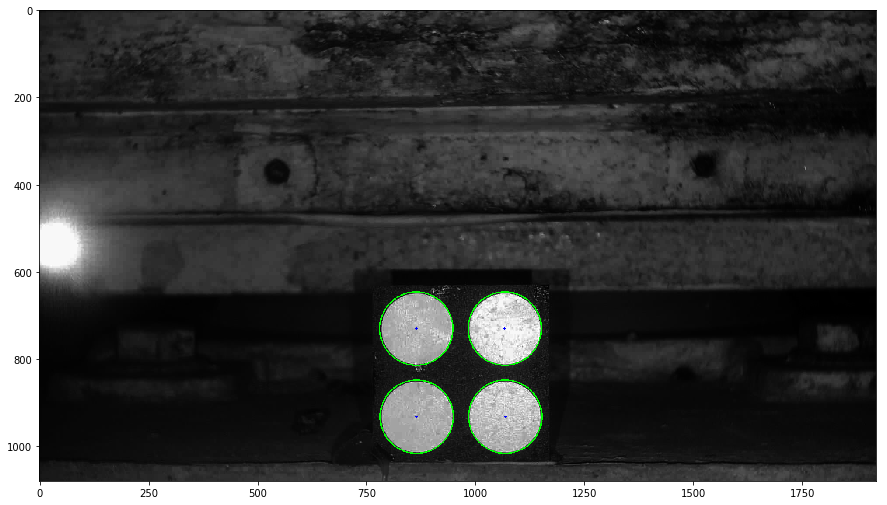

In [369]:
img_path = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2020/data/Img_136_20201004_010100.jpg'
img = imread(img_path)
dest_img = img.copy()


if gamma != 1.0 :  
    img = adjust_gamma(img, gamma=gamma)

if binarization : 
    img = adaptiveThreshold_3ch(img, min_rad)

centers, r_estimated, metric = imfindcircles(img, 
                                             [params['min_rad'], params['max_rad']],
                                            sensitivity = 0.98)
circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
circles = np.squeeze(circles)

if circles is not None: 
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(circles)) 
    for pt in circles: 
        a, b, r = pt[0], pt[1], pt[2]   
        # Draw the circumference of the circle. 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
        
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.draw()
else:
    plt.imshow(img)
    plt.draw()

In [17]:
disp, dest_circles = displacement_measure(dest_img,
                                          src_img,
                                          params = params,
#                                               src_circles = src_circles
                                          )
disp, dest_circles

(array([[ 2.17331936],
        [-2.33549185]]),
 array([[ 838.75471698,  785.66037736,   83.66600265],
        [ 846.48858447,  578.42922374,   83.66600265],
        [1044.34449761,  791.0430622 ,   83.66600265],
        [1050.80104712,  586.        ,   83.66600265]]))

In [86]:
result_folder = os.path.join("/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019", 'result', sensor_num)
Path(result_folder).mkdir(parents=True, exist_ok=True)

In [9]:
src_img = cv2.imread(img_list[15])

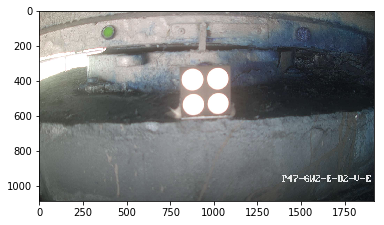

In [6]:
plt.imshow(src_img)

In [7]:
dest_img = cv2.imread(img_list[10])

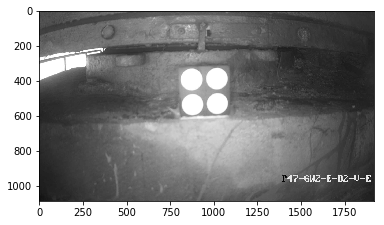

In [8]:
plt.imshow(dest_img)

In [10]:
disp, dest_circles = displacement_measure(dest_img,
                                          src_img,
                                          params = params,
#                                               src_circles = src_circles
                                          )
print(disp)

[[-0.85844702]
 [ 0.00283832]]


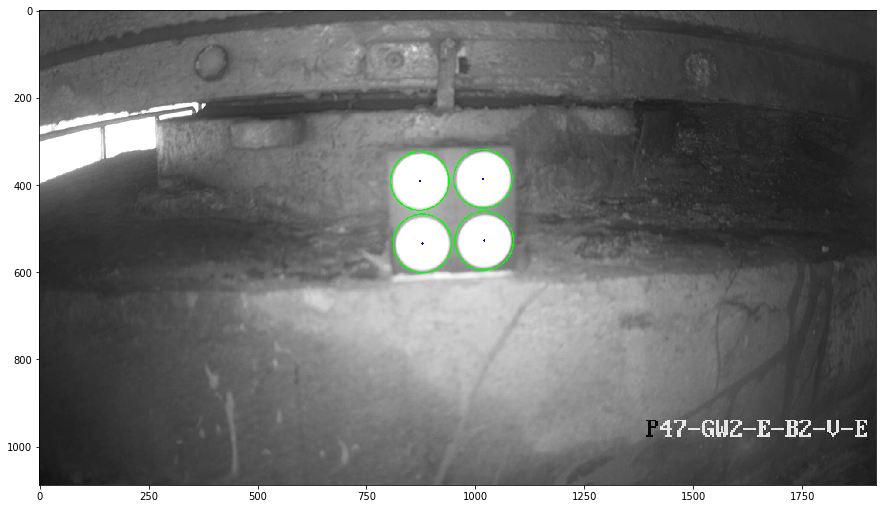

In [11]:
if dest_circles is not None: 
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(dest_circles)) 
    for pt in circles: 
        a, b, r = pt[0], pt[1], pt[2]   
        # Draw the circumference of the circle. 
        cv2.circle(dest_img, (a, b), r, (0, 255, 0), 2) 
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(dest_img, (a, b), 1, (0, 0, 255), 3) 
        
    plt.figure(figsize=(15, 15))
    plt.imshow(dest_img) 
else:
    plt.imshow(dest_img)

In [3]:
img_list = glob(os.path.join('/home/sss/Downloads/20201029_020', '*.jpg'))
img_list.sort()
img_list

['/home/sss/Downloads/20201029_020/Img_020_20201022_000100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_010101.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_020100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_030100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_040100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_050100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_060100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_070100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_080100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_090100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_100100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_110100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_120100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_130100.jpg',
 '/home/sss/Downloads/20201029_020/Img_020_20201022_140100.jpg',
 '/home/sss/Downloads/202

100%|██████████| 193/193 [04:26<00:00,  1.38s/it]


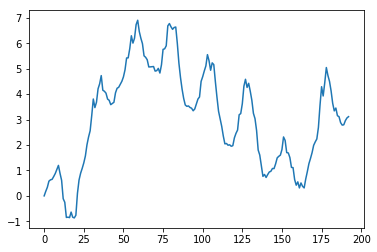

In [4]:
result = [] # 결과를 저장할 result list 

# 최초 source image에서 circle detection 수행 
src_img = cv2.imread(img_list[0])

if gamma != 1.0 :  
    src_img = adjust_gamma(src_img, gamma=gamma)

if binarization : 
    src_img = adaptiveThreshold_3ch(src_img, min_rad)

centers, r_estimated, metric = imfindcircles(src_img, 
                                             [min_rad, max_rad],
                                            sensitivity = sensitivity)

src_circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
src_circles = np.squeeze(src_circles)
# src_img = cv2.imread(img_list[0])
# 호출된 이미지 목록에서 displacement_measure 수행 
for img_path in tqdm(img_list): 
    dest_img = cv2.imread(img_path)
       
    '''
    변경사항
    1. 함수 이름을 displacement_measure로 변경하였습니다. 
    2. displacement_measure에 필요한 변수는 아래와 같습니다. 
        1) dest_img : 측정 대상 이미지 
        2) src_img : 고정점 이미지 
        3) src_circles : 고정점 이미지에서 탐지된 원들의 중심 좌표 및 지름 (고정점 이미지에서 변위 재측정 방지용)
        4) min_rad : 최소 원의 지름 크기 / max_rad : 최대 원의 지름 크기 
    '''
    disp, dest_circles = displacement_measure(dest_img,
                                              src_img,
                                              params = params,
                                              src_circles = src_circles
                                              )
    
    result.append(disp)
#     for dest_circle in dest_circles : 
#         dest_img = cv2.circle(dest_img, tuple(np.asarray(dest_circle[:2], dtype =np.int64)), int(dest_circle[2]), (0,255,0), thickness=1, lineType=8, shift=0)
#     cv2.imwrite(img_path[:-4] + '_with_circles_result.jpeg', dest_img)
    
collect_rslt = []
for rslt in result : 
    collect_rslt.append(rslt[0])
    
plt.plot(np.array(collect_rslt))

In [9]:
collect_rslt

[array([0.00201725]),
 array([0.17991754]),
 array([0.33817158]),
 array([0.57994139]),
 array([0.63254662]),
 array([0.6511079]),
 array([0.76020697]),
 array([0.88080888]),
 array([1.0414175]),
 array([1.19917599]),
 array([0.88692338]),
 array([0.61387159]),
 array([-0.10878013]),
 array([-0.24919268]),
 array([-0.84534309]),
 array([-0.83374439]),
 array([-0.85251717]),
 array([-0.6349098]),
 array([-0.83607809]),
 array([-0.86374637]),
 array([-0.75839151]),
 array([0.10333241]),
 array([0.62580157]),
 array([0.89247817]),
 array([1.08385669]),
 array([1.29830925]),
 array([1.56914767]),
 array([2.00796599]),
 array([2.31411796]),
 array([2.55830855]),
 array([3.15475912]),
 array([3.80662287]),
 array([3.4694977]),
 array([3.68068532]),
 array([4.20758544]),
 array([4.40346104]),
 array([4.72568593]),
 array([4.15136538]),
 array([4.11074026]),
 array([4.03655317]),
 array([3.80493917]),
 array([3.75550244]),
 array([3.58467784]),
 array([3.63257755]),
 array([3.67819172]),
 arra

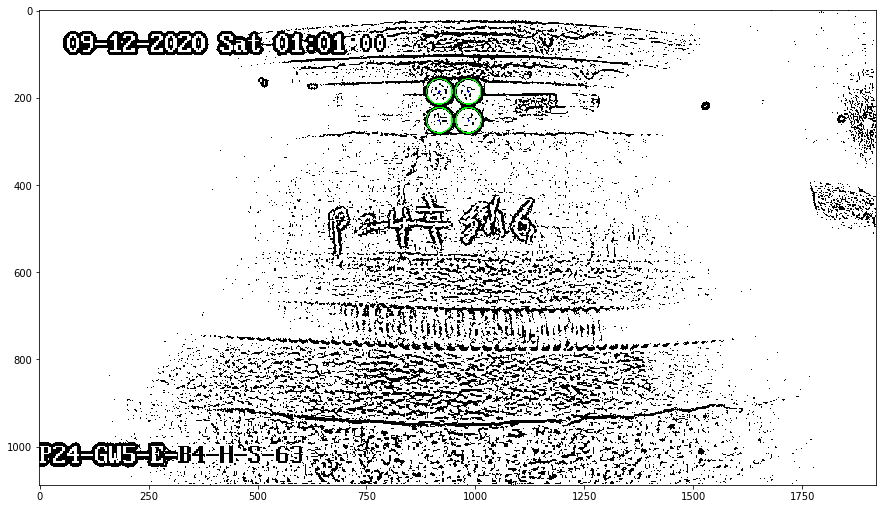

In [63]:
## check the circle detection accuracy 
min_rad = 21
max_rad = 40
img = imread(r'/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_035_20200912_010100.jpg') 
img1 = imread(r'/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_035_20200912_010100.jpg') 
# img = imread(r'/home/sss/Desktop/Img_023_20201023_010100.jpg') 

img = adjust_gamma(img, gamma=0.3)

# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# img[:,:,0] = clahe.apply(img[:,:,0])
# img[:,:,1] = clahe.apply(img[:,:,1])
# img[:,:,2] = clahe.apply(img[:,:,2])

img[:,:,0] = cv2.adaptiveThreshold(img[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,min_rad,2)

img[:,:,1] = cv2.adaptiveThreshold(img[:,:,1],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,min_rad,2)

img[:,:,2] = cv2.adaptiveThreshold(img[:,:,2],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,min_rad,2)



centers, r_estimated, metric = imfindcircles(img, 
                                             [min_rad, max_rad],
                                             sensitivity = 0.96)

circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
circles = np.squeeze(circles)
circles
# circles
# Draw circles that are detected. 
if circles is not None: 
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(circles)) 
    for pt in circles: 
        a, b, r = pt[0], pt[1], pt[2]   
        # Draw the circumference of the circle. 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
        
    plt.figure(figsize=(15, 15))
    plt.imshow(img) 
else:
    plt.imshow(img1)
    
    
    

In [316]:
circles

array([[984, 286,  32],
       [984, 218,  32],
       [916, 216,  32],
       [917, 286,  32]], dtype=uint16)

In [356]:
## check the circle detection accuracy 
min_rad = 70
max_rad = 100
img = imread(r'/home/sss/Desktop/tmp/Img_050_20200910_140100.jpg') 
# img1 = imread(r'/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_035_20200912_010100.jpg') 
# img = imread(r'/home/sss/Desktop/Img_023_20201023_010100.jpg') 

img = adjust_gamma(img, gamma=0.2)

# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# img[:,:,0] = clahe.apply(img[:,:,0])
# img[:,:,1] = clahe.apply(img[:,:,1])
# img[:,:,2] = clahe.apply(img[:,:,2])

# img[:,:,0] = cv2.adaptiveThreshold(img[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,min_rad,2)

# img[:,:,1] = cv2.adaptiveThreshold(img[:,:,1],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,min_rad,2)

# img[:,:,2] = cv2.adaptiveThreshold(img[:,:,2],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,min_rad,2)



# centers, r_estimated, metric = imfindcircles(img, 
#                                              [min_rad, max_rad],
#                                              sensitivity = 0.96)

# circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
# circles = np.squeeze(circles)
# circles
# # circles
# # Draw circles that are detected. 
# if circles is not None: 
#     # Convert the circle parameters a, b and r to integers. 
#     circles = np.uint16(np.around(circles)) 
#     for pt in circles: 
#         a, b, r = pt[0], pt[1], pt[2]   
#         # Draw the circumference of the circle. 
#         cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
#         # Draw a small circle (of radius 1) to show the center. 
#         cv2.circle(img, (a, b), 1, (0, 0, 255), 10) 
        
#     plt.figure(figsize=(15, 15))
#     plt.imshow(img) 
# else:
#     plt.imshow(img1)

cv2.imwrite('/home/sss/Desktop/tmp/Img_050_20200910_140100_gamma.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    
    

True